In [261]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## Non-stationary pricing environment

### Parameter definition

In [326]:
# Pricing Environment definition
class NonStationaryPricingEnv:
    def __init__(self, mu, cost):
        self.mu = mu
        self.cost = cost

    def round(self, p_t, n_t, t):
        conv_prob = self.mu[t]
        noise = int(np.random.normal(0, 4))
        d_t = n_t * conv_prob(p_t) + noise
        r_t = (p_t - self.cost)*d_t
        return d_t, r_t

In [327]:
# Utility function
def rescale(x, min_x, max_x):
    return min_x + (max_x-min_x)*x

In [328]:
# Parameters definition
max_price = 20
min_price = 10
cost = min_price # I set the cost to min price because that is the worst case for the seller (0 profit on a sale)

T = 10000 # number of rounds
daily_customers = 100

K = 100 # discretization intervals

reward_function = lambda price, cost, n_sales: (price - cost) * n_sales

prices = np.linspace(min_price,max_price, K) # 100 different prices between 10 and 20

In [329]:
conversion_probabilities = [
    lambda p: 1-p/max_price,  # linear demand curve
    lambda p: 1-p/max_price,  # linear demand curve
    lambda p: 1-p/max_price,  # linear demand curve
    lambda p: 1-p/max_price,  # linear demand curve
    lambda p: 1-p/max_price,  # linear demand curve
    lambda p: 1-p/max_price,  # linear demand curve
    lambda p: 1-p/max_price,  # linear demand curve
    lambda p: 1-p/max_price,  # linear demand curve
    lambda p: 1-p/max_price,  # linear demand curve
    lambda p: 1-p/max_price,  # linear demand curve
]

In [330]:
conversion_probabilities = [
    lambda p: 1-p/max_price,  # linear demand curve
    lambda p: 1-np.exp(-p/max_price),  # exponential demand curve
    lambda p: 1/(1+np.exp(-p/max_price)),  # logistic demand curve
    lambda p: 1 / (1 + np.log(p - min_price + 1)),  # logarithmic demand curve
    lambda p: 1 / (1 + np.sqrt(p - min_price)),  # square root demand curve
    lambda p: 1 / (1 + np.power(p - min_price, 2)),  # square demand curve
    lambda p: 1 / (1 + np.power(p - min_price, 3)),  # cubic demand curve
    lambda p: 1 / (1 + np.exp(0.1 * (p - (max_price + min_price) / 2))),  # sigmoid demand curve
    lambda p: min_price / p,  # inverse demand curve
    lambda p: np.sin(p/max_price)  # sine demand curve
]

In [331]:
conversion_probabilities = [
    lambda p: 1 / (1 + np.power(p - min_price, 2)),  # square demand curve
    lambda p: 1-p/max_price,  # linear demand curve
]

In [332]:
mu = [[conversion_probabilities[i]]*(T//len(conversion_probabilities)) for i in range(len(conversion_probabilities))]
mu = np.array(mu).flatten()

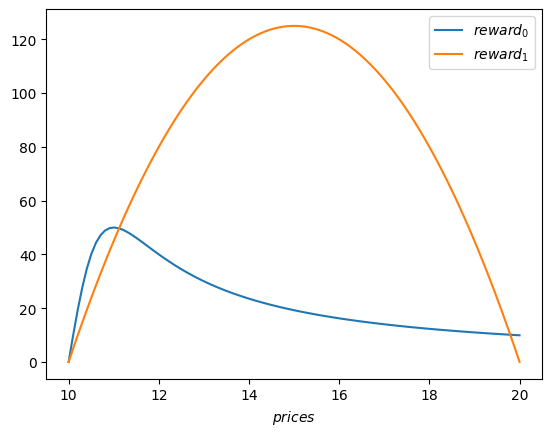

In [333]:
profit_curves_per_price = []
for p in prices:
    prob_per_price = []
    for i in range(len(conversion_probabilities)):
        conv_prob = conversion_probabilities[i]
        prob_per_price.append(reward_function(p, cost, daily_customers * conv_prob(p)))
    profit_curves_per_price.append(prob_per_price)

plt.plot(prices, profit_curves_per_price, label=[f'$reward_{i}$' for i in range(len(conversion_probabilities))])
plt.legend()
plt.xlabel('$prices$')
plt.show();

In [334]:
# let's compute the clairvoyant
# Each interval has a different conversion probability function and i calculate the best price for each interval
# The clayrvoiant will choose the best price for each interval and will sell to all the customers in the interval
best_prices = np.array([])
expected_clairvoyant_rewards = np.array([])
for t in range(T):
    conv_prob = mu[t]
    daily_profit_curve = reward_function(prices, cost, daily_customers * conv_prob(prices))
    best_price_index = np.argmax(daily_profit_curve)
    best_price = prices[best_price_index]
    best_prices = np.append(best_prices, best_price)
    expected_clairvoyant_rewards = np.append(expected_clairvoyant_rewards, daily_profit_curve[best_price_index])


100%|██████████| 10000/10000 [00:00<00:00, 25064.32it/s]


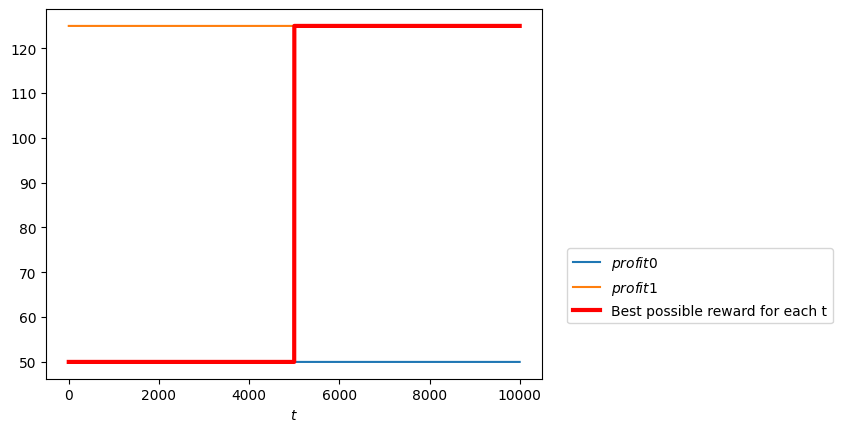

In [335]:
profits = []
for i in range(len(conversion_probabilities)):
    profit_per_prob = np.array([])
    conv_prob = conversion_probabilities[i]
    for t in tqdm(range(T)):
        daily_profit_curve = reward_function(prices, cost, daily_customers * conv_prob(prices))
        best_price_index = np.argmax(daily_profit_curve)
        profit_per_prob = np.append(profit_per_prob, daily_profit_curve[best_price_index])
    profits.append(profit_per_prob)

t = np.arange(T)
for i in range(len(conversion_probabilities)):
    plt.plot(t, profits[i], label=f'$profit{i}$')
plt.plot(t, expected_clairvoyant_rewards, label='Best possible reward for each t', linewidth=3, color='red')
plt.legend(loc=(1.05,0.15))
plt.xlabel('$t$')
plt.show();

### Sliding Window UCB1

In [272]:
class SWUCBAgent:
    def __init__(self, K, T, W, range=1):
        self.K = K
        self.T = T
        self.W = W
        self.range = range
        self.a_t = None
        self.cache = np.repeat(np.nan, repeats=K*W).reshape(W, K)
        self.N_pulls = np.zeros(K)
        self.t = 0
    
    def pull_arm(self):
        if self.t < self.K:
            self.a_t = self.t 
        else:
            n_pulls_last_w = self.W - np.isnan(self.cache).sum(axis=0)
            avg_last_w = np.nanmean(self.cache, axis=0)
            ucbs = avg_last_w + self.range*np.sqrt(2*np.log(self.W)/n_pulls_last_w)
            self.a_t = np.argmax(ucbs)
        return self.a_t
    
    def update(self, r_t):
        self.N_pulls[self.a_t] += 1
        self.cache = np.delete(self.cache, (0), axis=0) # remove oldest observation
        new_samples = np.repeat(np.nan, self.K)
        new_samples[self.a_t] = r_t
        self.cache = np.vstack((self.cache, new_samples)) # add new observation
        self.t += 1

In [274]:
K = len(prices) # number of arms
U = len(conversion_probabilities) # maximum number of abrupt changes
W = int(2*np.sqrt(T*np.log(T)/U)) # assuming U_T is known
W = 2000
print(f'K={K}, U={U}, W={W}')

n_trials = 2

mu = [[conversion_probabilities[i]]*(T//len(conversion_probabilities)) for i in range(len(conversion_probabilities))]
mu = np.array(mu).flatten()

regret_per_trial = []

for seed in tqdm(range(n_trials)):

    np.random.seed(seed)

    env = NonStationaryPricingEnv(mu, cost)
    ucb_agent = SWUCBAgent(K, T, W, range=max(expected_clairvoyant_rewards)
)

    agent_rewards = np.array([])
    chosen_prices = np.array([])
    for t in tqdm(range(T)):
        i = ucb_agent.pull_arm()
        p_t = prices[i]
        chosen_prices = np.append(chosen_prices, p_t)
        d_t, r_t = env.round(p_t, daily_customers, t)
        ucb_agent.update(r_t)
        agent_rewards = np.append(agent_rewards, r_t)

    cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)
    regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

K=10, U=2, W=2000


  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:18<00:00,  9.34s/it]


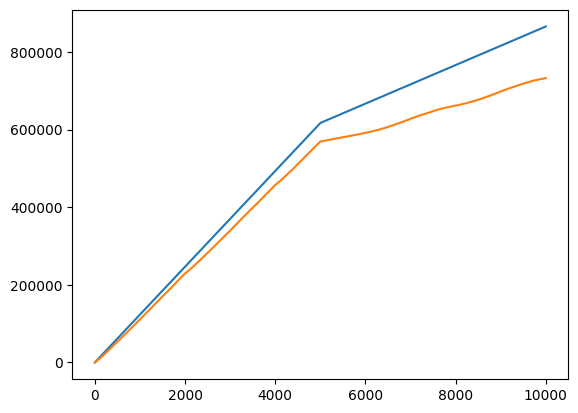

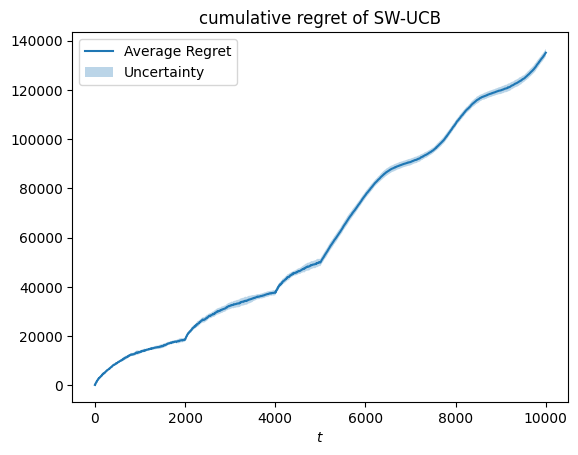

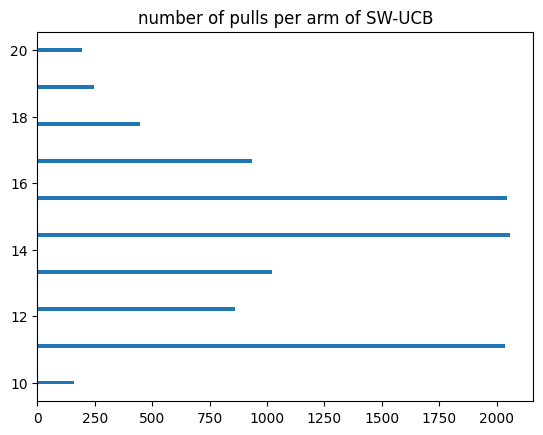

[16.66666667 15.55555556 15.55555556 14.44444444 14.44444444 14.44444444
 14.44444444 20.         15.55555556 13.33333333 16.66666667 15.55555556
 14.44444444 14.44444444 16.66666667 15.55555556 14.44444444 13.33333333
 16.66666667 14.44444444 15.55555556 13.33333333 17.77777778 11.11111111
 12.22222222 14.44444444 16.66666667 17.77777778 13.33333333 14.44444444
 16.66666667 16.66666667 15.55555556 17.77777778 16.66666667 12.22222222
 12.22222222 11.11111111 13.33333333 12.22222222 13.33333333 15.55555556
 14.44444444 15.55555556 17.77777778 13.33333333 15.55555556 14.44444444
 14.44444444 10.         12.22222222 14.44444444 14.44444444 15.55555556
 12.22222222 11.11111111 11.11111111 10.         15.55555556 14.44444444
 14.44444444 15.55555556 14.44444444 20.         14.44444444 14.44444444
 13.33333333 16.66666667 12.22222222 11.11111111 12.22222222 12.22222222
 14.44444444 13.33333333 17.77777778 13.33333333 12.22222222 15.55555556
 17.77777778 12.22222222 15.55555556 15.55555556 13

In [275]:
plt.plot(np.arange(T), np.cumsum(expected_clairvoyant_rewards), label='Cumulative clairvoyant reward')
plt.plot(np.arange(T), np.cumsum(agent_rewards), label='Cumulative agent reward')
plt.show()

plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('cumulative regret of SW-UCB')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.xlabel('$t$')
plt.legend()
plt.show()

plt.barh(y=prices, width=ucb_agent.N_pulls, height=0.1)
plt.title('number of pulls per arm of SW-UCB')
plt.show();

### CUSUM

In [336]:
class CUSUMUCBAgent:
    def __init__(self, K, T, M, h, alpha=0.99, range=1):
        self.K = K
        self.T = T
        self.M = M
        self.h = h
        self.alpha=alpha
        self.range = range
        self.a_t = None
        self.reset_times = np.zeros(K)
        self.N_pulls = np.zeros(K)
        self.all_rewards = [[] for _ in np.arange(K)]
        self.counters = np.repeat(M, K)
        self.average_rewards = np.zeros(K)
        self.n_resets = np.zeros(K)
        self.n_t = 0
        self.t = 0
    
    def pull_arm(self):
        if (self.counters > 0).any():
            for a in np.arange(self.K):
                if self.counters[a] > 0:
                    self.counters[a] -= 1
                    self.a_t = a
                    break
        else:
            if np.random.random() <= 1-self.alpha:
                ucbs = self.average_rewards + self.range*np.sqrt(np.log(self.n_t)/self.N_pulls)
                self.a_t = np.argmax(ucbs)
            else:
                self.a_t = np.random.choice(np.arange(self.K)) # extra exploration
        return self.a_t
    
    def update(self, r_t):
        self.N_pulls[self.a_t] += 1
        self.all_rewards[self.a_t].append(r_t)
        if self.counters[self.a_t] == 0:
            if self.change_detection():
                print(f'Change detected on arm {self.a_t} at time {self.t}')
                self.n_resets[self.a_t] +=1 
                self.N_pulls[self.a_t] = 0
                self.average_rewards[self.a_t] = 0
                self.counters[self.a_t] = self.M
                self.all_rewards[self.a_t] = []
                self.reset_times[self.a_t] = self.t 
            else:
                self.average_rewards[self.a_t] += (r_t - self.average_rewards[self.a_t])/self.N_pulls[self.a_t]
        self.n_t = sum(self.N_pulls)
        self.t += 1

    def change_detection(self):
        ''' CUSUM CD sub-routine. This function returns 1 if there's evidence that the last pulled arm has its average reward changed '''
        u_0 = np.mean(self.all_rewards[self.a_t][:self.M])
        sp, sm = (np.array(self.all_rewards[self.a_t][self.M:])- u_0, u_0 - np.array(self.all_rewards[self.a_t][self.M:]))
        gp, gm = 0, 0
        for sp_, sm_ in zip(sp, sm):
            gp, gm = max([0, gp + sp_]), max([0, gm + sm_])
            if max([gp, gm]) >= self.h:
                return True
        return False


In [337]:
K = len(prices)
U = len(conversion_probabilities) # maximum number of abrupt changes
h = 5*max(expected_clairvoyant_rewards)*np.log(T/U) # sensitivity of detection, threshold for cumulative deviation
alpha = np.sqrt(U*np.log(T/U)/T) # probability of extra exploration
M = int(2*np.log(T/U)) # robustness of change detection

n_trials = 5

regret_per_trial = []

for seed in range(n_trials):
    np.random.seed(seed)
    env = NonStationaryPricingEnv(mu, cost)
    ucb_agent = CUSUMUCBAgent(K, T, M, h, alpha, range=max(expected_clairvoyant_rewards))

    agent_rewards = np.array([])

    for t in tqdm(range(T)):
        a_t = ucb_agent.pull_arm()
        p_t = prices[a_t]
        d_t, r_t = env.round(p_t, daily_customers, t)
        ucb_agent.update(r_t)
        agent_rewards = np.append(agent_rewards, r_t)

    cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)
    regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

 53%|█████▎    | 5295/10000 [00:01<00:01, 3568.71it/s] 

Change detected on arm 18 at time 5176


 82%|████████▏ | 8205/10000 [00:09<00:01, 1059.68it/s]

Change detected on arm 61 at time 7779


 53%|█████▎    | 5273/10000 [00:01<00:01, 4176.02it/s] 

Change detected on arm 24 at time 5102


 54%|█████▎    | 5361/10000 [00:01<00:01, 4010.56it/s] 

Change detected on arm 18 at time 5174


 72%|███████▏  | 7157/10000 [00:04<00:03, 712.88it/s] 

Change detected on arm 51 at time 6837


 54%|█████▍    | 5378/10000 [00:01<00:01, 3142.94it/s]

Change detected on arm 35 at time 5185


 55%|█████▌    | 5516/10000 [00:01<00:01, 3137.28it/s]

Change detected on arm 18 at time 5175


 72%|███████▏  | 7194/10000 [00:04<00:03, 880.58it/s] 

Change detected on arm 51 at time 6872


100%|██████████| 10000/10000 [00:15<00:00, 651.79it/s]


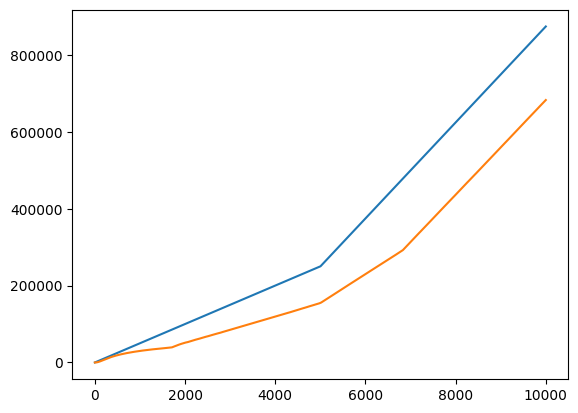

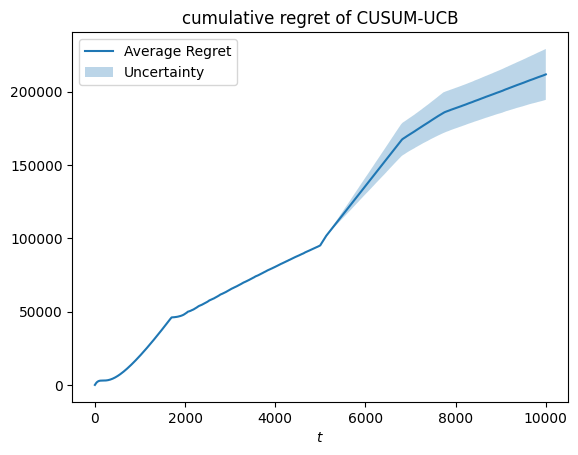

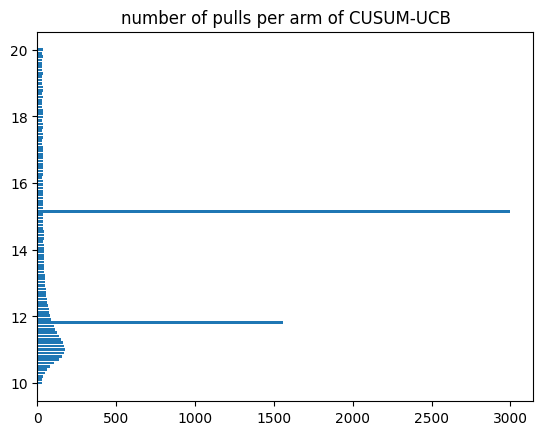

In [338]:
plt.plot(np.arange(T), np.cumsum(expected_clairvoyant_rewards), label='Cumulative clairvoyant reward')
plt.plot(np.arange(T), np.cumsum(agent_rewards), label='Cumulative agent reward')
plt.show()

plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('cumulative regret of CUSUM-UCB')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.xlabel('$t$')
plt.legend()
plt.show()

plt.barh(y=prices, width=ucb_agent.N_pulls, height=0.08)
plt.title('number of pulls per arm of CUSUM-UCB')
plt.show();

## Multiple products

In [279]:
# Environment definition
class MultiProductPricingEnv:
    def __init__(self, conversion_probabilities, costs):
        self.conversion_probabilities = conversion_probabilities
        self.costs = costs

    def round(self, p_t, n_t):
        d_t = np.array(len(conversion_probabilities))
        r_t = np.array(len(conversion_probabilities))
        for i in range(len(conversion_probabilities)):
            conv_prob = conversion_probabilities[i]
            d_t[i] = np.random.binomial(n_t, conv_prob(p_t[0], p_t[1]))
            r_t[i] = (p_t - self.costs[i])*d_t[i]
        return d_t, r_t

In [280]:
# Environment definition
class PricingEnvironment:
    def __init__(self, conversion_probability, cost):
        self.conversion_probability = conversion_probability
        self.cost = cost

    def round(self, p_t, n_t):
        d_t = np.random.binomial(n_t, self.conversion_probability(p_t))
        r_t = (p_t - self.cost)*d_t
        return d_t, r_t
    

In [281]:
# Utility function
def rescale(x, min_x, max_x):
    return min_x + (max_x-min_x)*x

In [282]:
# Parameters definition
max_price_1, min_price_1 = 50, 10
max_price_2, min_price_2 = 50, 20
min_price, max_price = min(min_price_1, min_price_2), max(max_price_1, max_price_2)
costs = [min_price_1, min_price_2]

T = 1000
daily_customers = 100
K = 100 # discretization intervals

conversion_probabilities = [
    lambda p1, p2: 1-p1/max_price,  # linear demand curve
    lambda p1, p2: (p1/max_price)*(1-p2/max_price)
]

reward_function = lambda price, cost, n_sales: (price - cost) * n_sales

prices = np.linspace(min_price,max_price, K) # 1000 different prices between 10 and 20

# let's compute the clairvoyant: it is the repetition for T times of the maximum daily profit
expected_clairvoyant_rewards = np.array([])
for t in range(T):
    daily_rewards = np.array([])
    best_prices = np.array([])
    for i in range(len(conversion_probabilities)):
        conv_prob = conversion_probabilities[i]
        daily_profit_curve = reward_function(prices, costs[i], daily_customers * conv_prob(prices, prices))
        best_price_index = np.argmax(daily_profit_curve)
        best_prices = np.append(best_prices, prices[best_price_index])
        daily_rewards = np.append(daily_rewards, daily_profit_curve[best_price_index])
    expected_clairvoyant_rewards = np.append(expected_clairvoyant_rewards, daily_rewards.sum())

In [339]:
# Gaussian Process definition
class RBFGaussianProcess:
    def __init__(self, scale=1, reg=1e-2):
        self.scale = scale 
        self.reg = reg
        self.k_xx_inv = None

    def rbf_kernel_incr_inv(self, B, C, D):
        temp = np.linalg.inv(D - C @ self.k_xx_inv @ B)
        block1 = self.k_xx_inv + self.k_xx_inv @ B @ temp @ C @ self.k_xx_inv
        block2 = - self.k_xx_inv @ B @ temp
        block3 = - temp @ C @ self.k_xx_inv
        block4 = temp
        res1 = np.concatenate((block1, block2), axis=1)
        res2 = np.concatenate((block3, block4), axis=1)
        res = np.concatenate((res1, res2), axis=0)
        return res

    def rbf_kernel(self, a, b):
        a_ = a.reshape(-1, 1)
        b_ = b.reshape(-1, 1)
        output = -1 * np.ones((a_.shape[0], b_.shape[0]))
        for i in range(a_.shape[0]):
            output[i, :] = np.power(a_[i] - b_, 2).ravel()
        return np.exp(-self.scale * output)
    
    def fit(self, x=np.array([]), y=np.array([])):
        x,y = np.array(x),np.array(y)
        if self.k_xx_inv is None:
            self.y = y.reshape(-1,1)
            self.x = x.reshape(-1,1)
            k_xx = self.rbf_kernel(self.x, self.x) + self.reg * np.eye(self.x.shape[0])
            self.k_xx_inv = np.linalg.inv(k_xx)
        else:
            B = self.rbf_kernel(self.x, x)
            self.x = np.vstack((self.x, x))
            self.y = np.vstack((self.y, y))
            self.k_xx_inv = self.rbf_kernel_incr_inv(B, B.T, np.array([1 + self.reg]))
        return self

    def predict(self, x_predict):
        k = self.rbf_kernel(x_predict, self.x)

        mu_hat = k @ self.k_xx_inv @ self.y
        sigma_hat = 1 - np.diag(k @ self.k_xx_inv @ k.T)

        return mu_hat.ravel(), sigma_hat.ravel()

In [340]:
# GPUCB Agent definition
# From the agent's point of view, action set is [0,1]. If the actual actions are outside this set, we can always perform a rescaling outside the class.
class GPUCBAgent:
    def __init__(self, T, discretization=100):
        self.T = T
        self.arms = np.linspace(0, 1, discretization)
        self.gp = RBFGaussianProcess(scale=2).fit()
        self.a_t = None
        self.action_hist = np.array([])
        self.reward_hist = np.array([])
        self.mu_t = np.zeros(discretization)
        self.sigma_t = np.zeros(discretization)
        self.gamma = lambda t: np.log(t+1)**2
        self.beta = lambda t: 1 + 0.5*np.sqrt(2 * (self.gamma(t) + 1 + np.log(T)))
        self.N_pulls = np.zeros(discretization)
        self.t = 0

    def pull_arm(self):
        self.mu_t, self.sigma_t = self.gp.predict(self.arms)
        ucbs = self.mu_t + self.beta(t) * self.sigma_t
        self.a_t = np.argmax(ucbs)
        return self.arms[self.a_t]

    def update(self, r_t):
        self.N_pulls[self.a_t] += 1
        self.action_hist = np.append(self.action_hist, self.arms[self.a_t])
        self.reward_hist = np.append(self.reward_hist, r_t)
        self.gp = self.gp.fit(self.arms[self.a_t], r_t)
        self.t += 1

In [ ]:
# Interaction between agent and environment
env = MultiProductPricingEnv(conversion_probabilities, costs)
agent = GPUCBAgent(T) # MDGP-UCB Agent

rewards = np.array([])
for t in tqdm(range(T)):
    p_t = agent.pull_arm()
    p_t = rescale(p_t, min_price, max_price) # p_t is a vector of 2 components (price for product 1 and price for product 2)
    d_t, r_t = env.round(p_t, n_t=daily_customers)
    agent.update(r_t/daily_customers)
    rewards = np.append(rewards, r_t.sum())

cumulative_regret = np.cumsum(expected_clairvoyant_rewards-rewards)

In [ ]:
prices = rescale(agent.action_hist, min_price, max_price)
profits = agent.reward_hist
gp = RBFGaussianProcess(scale=2)
gp.fit(prices, profits)
mu, sigma = gp.predict(np.linspace(10,20,100))
plt.scatter(prices, profits, label='Samples', color='C1')
plt.plot(np.linspace(10,20,100), mu, label='Average Normalized Profit')
plt.axvline(best_prices[i], color='red',label='Optimal Price')
plt.fill_between(np.linspace(10,20,100), mu-sigma, mu+sigma, alpha=0.3, label='Uncertainty', color='C0')
plt.title('GPUCB - Final estimated profit curve (normalized)')
plt.xlabel('Price')
plt.legend()
plt.show();

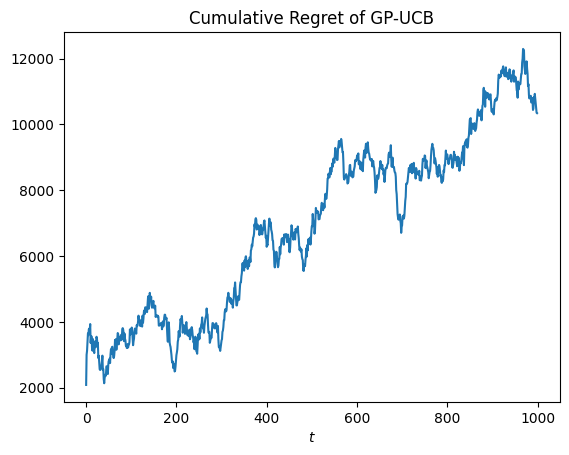

In [286]:
plt.figure()
plt.plot(cumulative_regret)
plt.title('Cumulative Regret of GP-UCB')
plt.xlabel('$t$')
plt.show();